In [1]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
from typing import Annotated, Literal, Sequence, TypedDict
import langchainhub as hub 
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import END, StateGraph, START
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import create_retriever_tool

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

##### it is having details about the tool condition we build our custom logic also


https://github.com/langchain-ai/langgraph/blob/main/libs/langgraph/langgraph/prebuilt/tool_node.py


why we use from langchain_core.pydantic_v1 import BaseModel, Field

The import statement:

```python
from langchain_core.pydantic_v1 import BaseModel, Field
```

indicates that you're working within the **LangChain ecosystem** and leveraging **Pydantic** for data validation and model creation. Here's a breakdown of **why and how** these components are used:

---

### **Why Use `BaseModel` and `Field` from Pydantic?**

Pydantic is a powerful library for data validation and settings management in Python. It is particularly well-suited for building models that ensure your data conforms to specific types and formats.

In the context of LangChain, **Pydantic's `BaseModel` and `Field`** are often used to define structured schemas for:

1. **Tool Input and Output Models:**

   - Define the input and output structure for tools or LLM-based functions.
   - Ensures the data being passed to or returned from the tools is valid and well-defined.

2. **Prompts and Contexts:**

   - Create reusable, structured representations of prompts or conversation states.

3. **Validation and Type Enforcement:**

   - Validate that data passed between components (e.g., tools, LLMs, and workflows) adheres to expected types and constraints.

4. **Better Readability and Debugging:**
   - Explicitly define schemas for tools and workflows, making your code easier to understand and debug.

---

### **How These Components Work**

#### **1. `BaseModel`**

Pydantic's `BaseModel` is the foundation for creating structured models. It allows you to:

- Define the expected fields of a model.
- Add validation logic for those fields.
- Automatically handle type coercion and validation errors.

#### **2. `Field`**

The `Field` class is used to:

- Add metadata, constraints, or default values to model fields.
- Document the purpose of each field.

---

### **Examples**

#### **Tool Input Model**

Suppose you are defining a tool that takes user input. You can use `BaseModel` and `Field` to structure the expected input:

```python
from langchain_core.pydantic_v1 import BaseModel, Field

class MathToolInput(BaseModel):
    number1: float = Field(..., description="The first number for the operation")
    number2: float = Field(..., description="The second number for the operation")
    operation: str = Field(..., description="The operation to perform: add, subtract, multiply, or divide")

# Example usage
input_data = MathToolInput(number1=10, number2=5, operation="add")
print(input_data.dict())  # {'number1': 10.0, 'number2': 5.0, 'operation': 'add'}
```

This ensures:

- Only valid operations (e.g., "add") are processed.
- Invalid or missing data raises a clear validation error.

---

#### **Structured Prompts**

You can use `BaseModel` to create reusable, structured prompts for LLMs:

```python
class SummarizationPrompt(BaseModel):
    text: str = Field(..., description="The text to summarize")
    max_length: int = Field(100, description="Maximum length of the summary")

prompt = SummarizationPrompt(text="This is a long article...", max_length=50)
print(prompt.dict())  # {'text': 'This is a long article...', 'max_length': 50}
```

---

#### **Tool Input Validation**

You can integrate these models directly into LangChain tools:

```python
from langchain_core.pydantic_v1 import BaseModel
from langchain.tools import BaseTool

class RetrieveBlogPostsInput(BaseModel):
    query: str = Field(..., description="The search query for blog posts")
    max_results: int = Field(10, description="The maximum number of blog posts to return")

class RetrieveBlogPostsTool(BaseTool):
    name = "retrieve_blog_posts"
    description = "Retrieve blog posts based on a search query"
    args_schema = RetrieveBlogPostsInput  # Link the schema

    def _run(self, query: str, max_results: int):
        return f"Retrieved {max_results} results for query: {query}"

# Example usage
tool = RetrieveBlogPostsTool()
print(tool.run(query="AI advancements", max_results=5))  # Retrieves the results
```

---

### **Benefits of Using `BaseModel` and `Field`**

1. **Type Safety:**
   - Ensures data integrity across components.
2. **Descriptive Errors:**

   - Automatically raises clear validation errors for invalid input.

3. **Reusability:**

   - Define input/output models once and reuse them in multiple tools or workflows.

4. **Self-Documentation:**

   - The `Field` metadata (e.g., `description`) makes your code easier to understand and maintain.

5. **Interoperability:**
   - These structured models are compatible with LangChain's tooling and workflows, making them a natural choice in this ecosystem.

---

Let me know if you’d like help with implementing these models for your specific use case! 😊


In [7]:
%pip install -U langchain-google-genai langchain-groq
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash") 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
%pip install -U langchain-huggingface langchain-groq
%pip install -U sentence-transformers
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")

Defaulting to user installation because normal site-packages is not writeable
  Using cached huggingface_hub-0.36.2-py3-none-any.whl.metadata (15 kB)
Using cached huggingface_hub-0.36.2-py3-none-any.whl (566 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.4.1
    Uninstalling huggingface_hub-1.4.1:
      Successfully uninstalled huggingface_hub-1.4.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 5.2.0 requires huggingface-hub<2.0,>=1.3.0, but you have huggingface-hub 0.36.2 which is incompatible.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached huggingface_hub-1.4.1-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-1.4.1-py3-none-any.whl (553 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 0.36.2
    Uninstalling huggingface_hub-0.36.2:
      Successfully uninstalled huggingface_hub-0.36.2
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-huggingface 1.2.0 requires huggingface-hub<1.0.0,>=0.33.4, but you have huggingface-hub 1.4.1 which is incompatible.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Loading weights: 100%|█████████████████████| 103/103 [00:00<00:00, 216.98it/s, Materializing param=pooler.dense.weight]
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [10]:
from langchain_groq import ChatGroq

# 1. Using Llama 3.1 8B (The direct, faster replacement for Gemma)
# 2. 'model' is the modern parameter name (replaces model_name)
llm = ChatGroq(
    model="llama-3.1-8b-instant", 
    temperature=0
)

# Test immediately to verify
try:
    response = llm.invoke("hi hello how are you?")
    print("✅ Success! Response:")
    print(response.content)
except Exception as e:
    print(f"❌ Error: {e}")

✅ Success! Response:
Hello. I'm just a computer program, so I don't have feelings like humans do, but I'm functioning properly and ready to help with any questions or tasks you have. How can I assist you today?


In [11]:
url= "https://lilianweng.github.io/posts/2023-06-23-agent/"

In [12]:
WebBaseLoader(url).load()

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [13]:
WebBaseLoader(url).load()[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [14]:
description=WebBaseLoader(url).load()[0].metadata["description"]

In [15]:
description

'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model 

In [16]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [17]:
docs = [WebBaseLoader(url).load() for url in urls]

In [18]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [19]:
docs_list = [item for sublist in docs for item in sublist]

In [20]:
docs_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [24]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

# 1. Re-load properly to ensure it's not a nested list
url = "https://lilianweng.github.io/posts/2023-06-23-agent/"
loader = WebBaseLoader(url)
docs = loader.load() # This returns [Document(page_content=...)]

# 2. Setup the splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, 
    chunk_overlap=200
)

# 3. Split the documents
# We use docs (the list), and the splitter will look for .page_content inside each item
splits = text_splitter.split_documents(docs)

print(f"✅ Created {len(splits)} chunks successfully!")
print(f"Sample content from first chunk: {splits[0].page_content[:50]}...")

✅ Created 66 chunks successfully!
Sample content from first chunk: LLM Powered Autonomous Agents | Lil'Log










...


In [25]:
doc_splits=text_splitter.split_documents(docs_list)

In [26]:
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [27]:
vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
    
)

In [28]:
retriever=vectorstore.as_retriever()

In [29]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    
)

In [30]:
tools=[retriever_tool]

In [31]:
retrieve=ToolNode([retriever_tool])

In [32]:
llm_with_tools=llm.bind_tools(tools)

In [33]:
llm_with_tools.invoke(["hi how are you can you tell me what is india's capital?"])

AIMessage(content="I'm doing well, thank you for asking. India's capital is New Delhi.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 400, 'total_tokens': 418, 'completion_time': 0.028406664, 'completion_tokens_details': None, 'prompt_time': 0.021956279, 'prompt_tokens_details': None, 'queue_time': 0.045281701, 'total_time': 0.050362943}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c819a-debf-7b51-8bda-a0dd59c506f6-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 400, 'output_tokens': 18, 'total_tokens': 418})

In [34]:
llm_with_tools.invoke(["who is a prime minister of india?"])

AIMessage(content="I'm not aware of any specific information about the current Prime Minister of India. However, I can suggest some possible ways to find the answer. \n\nYou can check the official website of the Government of India or look for reliable news sources for the most up-to-date information.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 394, 'total_tokens': 450, 'completion_time': 0.082328932, 'completion_tokens_details': None, 'prompt_time': 0.021910659, 'prompt_tokens_details': None, 'queue_time': 0.045993891, 'total_time': 0.104239591}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c819b-0c79-7f41-81de-bb188b228931-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 394, 'output_tokens': 56, 'total_tokens': 450})

In [35]:
llm_with_tools.invoke(["hi can you tell me what is llm agent?"])

AIMessage(content='LLM stands for Large Language Model. An LLM agent is a type of artificial intelligence (AI) model that is designed to process and generate human-like language. It\'s a computer program that can understand, interpret, and respond to natural language inputs, such as text or voice commands.\n\nLLM agents are typically trained on vast amounts of text data, which allows them to learn patterns and relationships in language. This training enables them to generate coherent and contextually relevant responses to a wide range of questions and prompts.\n\nSome common applications of LLM agents include:\n\n1. Virtual assistants: LLM agents can be used to power virtual assistants like Siri, Alexa, or Google Assistant, which can understand voice commands and respond accordingly.\n2. Chatbots: LLM agents can be used to build chatbots that can engage in conversations with humans, providing customer support, answering questions, or offering recommendations.\n3. Language translation: 

In [36]:
llm_with_tools.invoke(["How does short-term memory (in-context learning) differ from long-term memory in an LLM-powered autonomous agent system?"])

AIMessage(content='In an LLM-powered autonomous agent system, short-term memory (in-context learning) and long-term memory serve distinct purposes and have different characteristics.\n\nShort-term memory, also known as in-context learning, refers to the ability of an LLM to process and respond to a specific input or context within a single interaction or session. This type of memory is typically limited to the current conversation or task and is often used for tasks that require understanding and responding to a specific prompt or question.\n\nLong-term memory, on the other hand, refers to the ability of an LLM to store and retrieve information over an extended period, often across multiple interactions or sessions. This type of memory is used for tasks that require knowledge retention, such as learning from experience, adapting to new situations, and making decisions based on past events.\n\nKey differences between short-term and long-term memory in LLM-powered autonomous agent system

Certainly! Let's break down the code:

### **Code Breakdown:**

```python
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
```

This code defines a class `AgentState` that is a **`TypedDict`**, which is a special kind of dictionary with fixed keys and value types, used to provide better type safety and autocompletion in Python.

Here’s a breakdown of each part:

---

### **1. `AgentState(TypedDict)`**

- **`TypedDict`**: This is a special class provided by `typing` that allows you to define dictionaries where each key has a fixed type. The dictionary keys are usually predefined, and each key must have a specified type.

  - `AgentState` here is a subclass of `TypedDict`, meaning `AgentState` will represent a dictionary where the types of its values are enforced.

  - Example:
    ```python
    agent_state = AgentState(messages=["Message 1", "Message 2"])  # This would be valid.
    ```

---

### **2. `messages: Annotated[Sequence[BaseMessage], add_messages]`**

- **`messages`**: This is a key in the `AgentState` dictionary. It holds a sequence (like a list or tuple) of `BaseMessage` objects.
- **`Annotated[...]`**: `Annotated` is used to attach additional metadata or annotations to the type. It’s a way to add extra information to the type system without affecting the actual type. In this case, it provides metadata for the `messages` field.

  - The **`Annotated`** wrapper allows you to define a type and also include additional information that might be used by tools like static analyzers or for other purposes like validation.

- **`Sequence[BaseMessage]`**: This indicates that `messages` should be a sequence (e.g., a list or tuple) of `BaseMessage` objects.

  - **`BaseMessage`** is likely a class that represents a message in the context of your program. It could have fields like `content`, `sender`, `timestamp`, etc.

- **`add_messages`**: This is a special annotation (or metadata) that likely refers to some function or constant that’s being added as additional context. The specific role of `add_messages` will depend on how it's defined elsewhere in the codebase.

  - **`add_messages`** could be a function, validator, or modifier that helps manage or process the messages in some way, but it's not directly modifying the type of `messages`. It's simply metadata for the type checker or other parts of the system.

  - For example, if `add_messages` were a function, it could be used in a custom decorator, validation system, or simply as an indication of how to handle messages.

---

### **Putting It All Together:**

- **`AgentState`** is a dictionary where one of the keys, `messages`, is specifically typed to be a **sequence of `BaseMessage`** objects. The sequence is annotated with **`add_messages`**, which provides additional metadata but doesn’t affect the type directly.
- **Example of `AgentState` usage:**

```python
from typing import TypedDict, Sequence
from typing_extensions import Annotated

class BaseMessage:
    def __init__(self, content: str):
        self.content = content

# Defining the `AgentState` TypedDict
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], "add_messages"]

# Example usage
message1 = BaseMessage("Hello, world!")
message2 = BaseMessage("How are you?")
state = AgentState(messages=[message1, message2])

print(state)
```

In the above code:

- `AgentState` is a dictionary with a `messages` field that is a sequence of `BaseMessage` objects.
- `add_messages` is metadata associated with the `messages` field, which can help guide the usage or interpretation of the data.

---

### **Summary:**

- `AgentState` is a dictionary where the `messages` key holds a sequence of `BaseMessage` objects.
- `Annotated[Sequence[BaseMessage], add_messages]` means that `messages` is a sequence of `BaseMessage` objects with additional metadata (`add_messages`).
- The annotation `add_messages` provides extra context or metadata that doesn't alter the type directly but can be used for purposes like validation or other system-specific behavior.

Let me know if you'd like further clarification on any part of this! 😊


In [37]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [38]:
'''def handle_query(query):
    print(query[0])
    if "prompt" in query[0] or "agent" in query[0]:
        return llm_with_tools.invoke(query)  # Use tool-bound LLM
    else:
        return llm.invoke(query)  # Use LLM directly without tool'''

'def handle_query(query):\n    print(query[0])\n    if "prompt" in query[0] or "agent" in query[0]:\n        return llm_with_tools.invoke(query)  # Use tool-bound LLM\n    else:\n        return llm.invoke(query)  # Use LLM directly without tool'

In [39]:
def ai_assistant(state:AgentState):
    print("---CALL AGENT---")
    messages = state['messages']
    print(f"this is my message: {messages}")
    
    if len(messages)>1:
        response=llm.invoke(messages[-1].content)
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        return {"messages": [response]}

In [40]:
{"messages":["hi hello how are you?"]}

{'messages': ['hi hello how are you?']}

In [41]:
ai_assistant({"messages":["hi hello how are you?"]})

---CALL AGENT---
this is my message: ['hi hello how are you?']


{'messages': [AIMessage(content="I'm doing well, thank you for asking. It's nice to chat with you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 392, 'total_tokens': 418, 'completion_time': 0.032414019, 'completion_tokens_details': None, 'prompt_time': 0.021700623, 'prompt_tokens_details': None, 'queue_time': 0.046888727, 'total_time': 0.054114642}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c819d-4315-7ba3-acc7-9d069b20831c-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 392, 'output_tokens': 26, 'total_tokens': 418})]}

In [42]:
ai_assistant({"messages":["what is autonomous agent"]})

---CALL AGENT---
this is my message: ['what is autonomous agent']


{'messages': [AIMessage(content="An autonomous agent is a software system that can perform tasks independently, making decisions and taking actions without direct human intervention. Autonomous agents are designed to operate in dynamic environments, adapting to changing conditions and learning from experience.\n\nAutonomous agents can be found in various domains, including:\n\n1. Robotics: Autonomous robots can navigate and interact with their environment, performing tasks such as assembly, cleaning, or exploration.\n2. Artificial Intelligence (AI): Autonomous AI systems can analyze data, make decisions, and take actions in areas like natural language processing, computer vision, or predictive analytics.\n3. Cyber-Physical Systems: Autonomous agents can control and coordinate physical systems, such as smart grids, transportation systems, or industrial automation.\n\nCharacteristics of autonomous agents include:\n\n1. Autonomy: The ability to operate independently, making decisions and 

Let's break down the code:

```python
class grade(BaseModel):
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")
```

This code defines a **Pydantic model** called `grade`, which is a subclass of **`BaseModel`**. The model is used to enforce the structure and data validation for a specific object. Here’s a detailed breakdown of each part:

---

### **1. `class grade(BaseModel):`**

- **`BaseModel`**: This is a class from the **Pydantic** library. By subclassing `BaseModel`, the `grade` class inherits Pydantic's functionality, which includes data validation, parsing, and automatic type checks.

  - When you define a model with Pydantic's `BaseModel`, it ensures that the data being processed conforms to the defined types and validates the fields according to their specified types.

- **`grade`**: This is the name of the model. It represents a grading system (or some other form of assessment) with a specific field, `binary_score`.

---

### **2. `binary_score: str = Field(description="Relevance score 'yes' or 'no'")`**

- **`binary_score`**: This is a field in the `grade` model. It holds the score related to relevance.

  - It is typed as a `str` (string) and is expected to hold a value of `'yes'` or `'no'`.

- **`Field(description="Relevance score 'yes' or 'no'")`**:
  - **`Field`**: This is a Pydantic function that is used to add metadata to model fields. In this case, it describes the field in the model.
  - The **`description`** argument provides a brief explanation of what the field represents, which helps improve documentation and readability of the code. This metadata doesn't change the field's behavior but can be helpful for generating documentation or providing context.

---

### **What Does This Model Do?**

- **The `grade` model** represents an object where the `binary_score` field holds a string value, specifically `'yes'` or `'no'`, indicating a relevance score.
- The **`description`** metadata is useful for documenting that this field specifically holds a binary score, either 'yes' or 'no'.

---

### **Example Usage**

You can create an instance of this model and validate the data automatically, thanks to Pydantic:

```python
from pydantic import BaseModel, Field

# Define the grade model
class grade(BaseModel):
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")

# Example usage: create an instance of grade
score = grade(binary_score="yes")
print(score)
```

#### Output:

```python
grade(binary_score='yes')
```

- If you try to create an instance with a value other than `'yes'` or `'no'`, Pydantic will raise a validation error, because the type and values are strictly defined.

#### Invalid Example:

```python
score = grade(binary_score="maybe")  # Raises validation error
```

#### Error:

```python
pydantic.error_wrappers.ValidationError: 1 validation error for grade
binary_score
  value is not a valid string (type=value_error.str)
```

---

### **Summary:**

- The **`grade` model** defines a **binary relevance score** (`binary_score`), where the score should be `'yes'` or `'no'`.
- **Pydantic's `Field`** is used to add a description to this field, explaining its purpose.
- By subclassing `BaseModel`, this model automatically provides data validation, ensuring that the `binary_score` is a valid string and provides automatic error handling if invalid data is provided.

Let me know if you'd like further explanation or examples! 😊


In [43]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no'")

In [44]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]
    print(f"message from the grader: {messages}")
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

### from langchain hub we can fetch the prompt


In [58]:
from langchainhub import Client

# 1. Initialize the Hub Client
client = Client()

# 2. Pull the prompt using the client instance
prompt = client.pull("rlm/rag-prompt")

print("✅ SUCCESS: Prompt pulled from the Hub!")

C:\Users\basun\AppData\Local\Temp\ipykernel_33020\2886993380.py:7: DeprecationWarning: The `langchainhub sdk` is deprecated.
Please use the `langsmith sdk` instead:
  pip install langsmith
Use the `pull_prompt` method.
  prompt = client.pull("rlm/rag-prompt")
C:\Users\basun\AppData\Roaming\Python\Python313\site-packages\langchainhub\client.py:326: DeprecationWarning: The `langchainhub sdk` is deprecated.
Please use the `langsmith sdk` instead:
  pip install langsmith
Use the `pull_prompt` method.
  res_dict = self.pull_repo(owner_repo_commit)


✅ SUCCESS: Prompt pulled from the Hub!


In [59]:
from langchain_core.prompts import PromptTemplate

# 1. Since 'prompt' is a string, print it directly
print("✅ Prompt string received:")
print(prompt)

# 2. Convert that string into a LangChain Prompt Object 
# (This is what the rest of your code expects)
prompt_object = PromptTemplate.from_template(prompt)

print("\n✅ Successfully converted to Prompt Object!")

✅ Prompt string received:
{"id": ["langchain", "prompts", "chat", "ChatPromptTemplate"], "lc": 1, "type": "constructor", "kwargs": {"messages": [{"id": ["langchain", "prompts", "chat", "HumanMessagePromptTemplate"], "lc": 1, "type": "constructor", "kwargs": {"prompt": {"id": ["langchain", "prompts", "prompt", "PromptTemplate"], "lc": 1, "type": "constructor", "kwargs": {"template": "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:", "input_variables": ["question", "context"], "template_format": "f-string"}}}}], "input_variables": ["question", "context"]}}

✅ Successfully converted to Prompt Object!


In [62]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]
    
    print(f"here is message from generate: {messages}")
    
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")
    
    return {"messages": [response]}

In [63]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    print(f"here is message from rewrite: {messages}")
    
    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [64]:
workflow=StateGraph(AgentState)
workflow.add_node("My_AI_Assistant",ai_assistant)
workflow.add_node("Vector_Retriever", retrieve) 
workflow.add_node("Query_Rewriter", rewrite) 
workflow.add_node("Output_Generator", generate)

In [65]:
workflow.add_edge(START,"My_AI_Assistant")

In [66]:
workflow.add_conditional_edges("My_AI_Assistant",
                               tools_condition,
                               {"tools": "Vector_Retriever",
                                END: END,})

In [67]:
workflow.add_conditional_edges("Vector_Retriever",
                            grade_documents,
                            {"generator": "Output_Generator",
                            "rewriter": "Query_Rewriter"
                            }
                            )
                            

In [68]:
workflow.add_edge("Output_Generator", END)

In [69]:
workflow.add_edge("Query_Rewriter", "My_AI_Assistant")

In [70]:
app=workflow.compile()

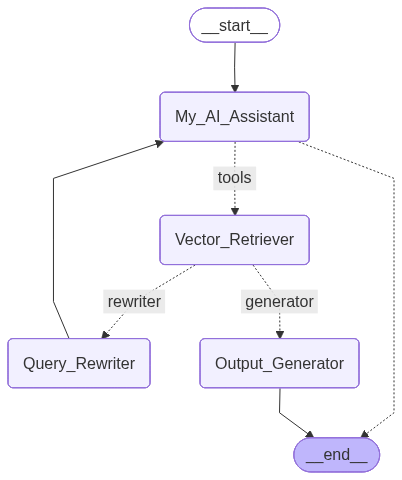

In [71]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [72]:
app.invoke({"messages":["What is a Autonomous Agent?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='630cf573-32ef-4807-b098-87514f87ae43')]


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='630cf573-32ef-4807-b098-87514f87ae43'),
  AIMessage(content='An autonomous agent is a software system that can perform tasks independently, making decisions and taking actions without direct human intervention. Autonomous agents are designed to operate in dynamic environments, adapting to changing conditions and learning from experience. They often use artificial intelligence (AI) and machine learning (ML) techniques to reason, learn, and interact with their surroundings.\n\nAutonomous agents can be found in various domains, such as:\n\n1. Robotics: Autonomous robots can navigate and interact with their environment, performing tasks like assembly, cleaning, or exploration.\n2. Virtual assistants: Virtual assistants like Siri, Alexa, or Google Assistant can understand voice commands, perform tasks, and provide information.\n3. Autonomous vehicles: Self-driving cars and drone

In [73]:
app.invoke({"messages":["What is a prompt engineering?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='What is a prompt engineering?', additional_kwargs={}, response_metadata={}, id='f7ff63ed-4caa-4397-9f70-73f8bd256199')]


{'messages': [HumanMessage(content='What is a prompt engineering?', additional_kwargs={}, response_metadata={}, id='f7ff63ed-4caa-4397-9f70-73f8bd256199'),
  AIMessage(content='Prompt engineering is the process of designing and optimizing text prompts to elicit specific and accurate responses from language models. It involves understanding the capabilities and limitations of language models, as well as the nuances of human language, to craft prompts that are clear, concise, and effective.\n\nPrompt engineering is a crucial aspect of working with language models, as it can significantly impact the quality and accuracy of the responses generated. By carefully crafting prompts, developers and users can:\n\n1. Improve the accuracy of language models by providing clear and specific instructions.\n2. Reduce the risk of misinterpretation or miscommunication.\n3. Increase the efficiency of language models by providing relevant and focused information.\n4. Enhance the overall user experience by

In [74]:
app.invoke({"messages":["who is a current prime minister of india?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='who is a current prime minister of india?', additional_kwargs={}, response_metadata={}, id='ce8041dd-8a2d-42ed-8d55-645cb0dc4e56')]


{'messages': [HumanMessage(content='who is a current prime minister of india?', additional_kwargs={}, response_metadata={}, id='ce8041dd-8a2d-42ed-8d55-645cb0dc4e56'),
  AIMessage(content="I'm not aware of any information about the current Prime Minister of India. However, I can suggest some possible ways to find out. \n\nYou can check the official website of the Prime Minister of India or the official website of the Government of India to get the latest information. You can also check reputable news sources or online encyclopedias like Wikipedia for the most up-to-date information.\n\nIf you want to know the current Prime Minister of India, I can suggest checking the official website of the Prime Minister of India or the official website of the Government of India.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 115, 'prompt_tokens': 395, 'total_tokens': 510, 'completion_time': 0.150583962, 'completion_tokens_details': None, 'prompt_time': 0.022159787, 

In [75]:
app.invoke({"messages":["what is solar eclips?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='what is solar eclips?', additional_kwargs={}, response_metadata={}, id='4856b265-de3a-44a4-a8c4-fd739730108d')]


{'messages': [HumanMessage(content='what is solar eclips?', additional_kwargs={}, response_metadata={}, id='4856b265-de3a-44a4-a8c4-fd739730108d'),
  AIMessage(content="A solar eclipse occurs when the Moon passes directly between the Earth and the Sun, blocking part or all of the Sun's light. This can only happen during a new moon, when the Moon is between the Earth and the Sun. There are three types of solar eclipses: partial, annular, and total.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 391, 'total_tokens': 455, 'completion_time': 0.062141574, 'completion_tokens_details': None, 'prompt_time': 0.021688135, 'prompt_tokens_details': None, 'queue_time': 0.045744285, 'total_time': 0.083829709}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c81aa-9641-7561-abd5-221c069b13f3-0', tool_calls=

In [76]:
app.invoke({"messages":["how we can use data structure for fundamental part of planning?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='how we can use data structure for fundamental part of planning?', additional_kwargs={}, response_metadata={}, id='2c5e70b8-e759-4f4d-a1e5-3b9902d92571')]


{'messages': [HumanMessage(content='how we can use data structure for fundamental part of planning?', additional_kwargs={}, response_metadata={}, id='2c5e70b8-e759-4f4d-a1e5-3b9902d92571'),
  AIMessage(content="Data structures play a crucial role in planning, as they help to efficiently represent and manipulate the problem's state, goals, and constraints. Here are some fundamental data structures used in planning:\n\n1. **Graphs**: Representing the problem's state as a graph, where nodes represent states and edges represent actions or transitions between states. Graphs are useful for planning in domains with complex state spaces, such as robotics or logistics.\n2. **Trees**: Representing the problem's state as a tree, where nodes represent states and edges represent actions or decisions. Trees are useful for planning in domains with a clear hierarchy or structure, such as decision-making or resource allocation.\n3. **Queues**: Representing a list of tasks or actions to be executed, whe

In [78]:
app.invoke({"messages":["what finance minister does for fundamental planning?"]})

---CALL AGENT---
this is my message: [HumanMessage(content='what finance minister does for fundamental planning?', additional_kwargs={}, response_metadata={}, id='3ba61225-a67f-4577-84f9-afd34b7a6372')]


{'messages': [HumanMessage(content='what finance minister does for fundamental planning?', additional_kwargs={}, response_metadata={}, id='3ba61225-a67f-4577-84f9-afd34b7a6372'),
  AIMessage(content="The finance minister is responsible for developing and implementing the country's financial policies, which includes fundamental planning. This involves setting fiscal goals, allocating resources, and making key decisions that impact the economy.\n\nSome of the key responsibilities of a finance minister in relation to fundamental planning include:\n\n1. **Economic forecasting**: The finance minister works with economists and other experts to forecast the country's economic growth, inflation, and other key indicators.\n2. **Budget preparation**: The finance minister prepares the national budget, which outlines projected revenues and expenditures for the upcoming fiscal year.\n3. **Fiscal policy formulation**: The finance minister develops and implements fiscal policies that aim to achieve e